In [101]:
#Celda para librerías
import sklearn as sk


import matplotlib as plt
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors

# LightGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb

# XGBoost
from xgboost import XGBClassifier
#KNN
from sklearn.neighbors import KNeighborsClassifier
#Neural Network
from sklearn.neural_network import MLPClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier


from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score


import json

import warnings
warnings.filterwarnings('ignore')

print(np.__version__)
from ydata_profiling import ProfileReport
import os
print("Directorio actual:", os.getcwd())



# Have all columns appear when dataframes are displayed.
pd.set_option('display.max_columns', None) 
# Have 100 rows appear when a dataframe is displayed
pd.set_option('display.max_rows', 500)
# Display dimensions whenever a dataframe is printed out.
pd.set_option('display.show_dimensions', True)


#Importando los datos

app_train = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/application_train.csv')
"""
app_test = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/application_test.csv')
bureau = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/bureau_balance.csv')
credit_card_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/credit_card_balance.csv')
installments_payments = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/installments_payments.csv')
pos_cash_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/POS_CASH_balance.csv')
previous_application = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/previous_application.csv')
"""



app_train.drop(columns=['SK_ID_CURR'], inplace=True)
#Debido a un fallo que detecta que todas los valores de la columna DAYS_BIRTH 
# son nan cuando no es así, vamos a sustituir la columna por una nueva llamada AGE_INT
app_train['AGE_INT'] = app_train['DAYS_BIRTH']/-365
app_train['HAS_CHILDREN'] = np.where(app_train['CNT_CHILDREN'] > 0, 1, 0)
#variables_categoricas = app_train.select_dtypes(include=['object', 'category']).columns
#app_train[variables_categoricas] = app_train[variables_categoricas].astype('category')
#categoricas = variables_categoricas.tolist()
info = app_train.info()
print(info)
#describe = app_train.describe()
#print(describe)

1.23.5
Directorio actual: c:\Users\Yeray\Desktop\DATA_SCIENCE_ML\Home-Credit-TFG\JUPYTER_NOTEBOOKS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 123 entries, TARGET to HAS_CHILDREN
dtypes: float64(66), int32(1), int64(40), object(16)
memory usage: 287.4+ MB
None


In [102]:
#Feature Engineering


#Vamos a convertir la variable CNT_CHILDREN en una variable categórica que indique 1 si tiene hijos y 0 si no.

#Vamos a crear la variable DAYS_EMPLOYED en una variable categórica que indique 1 si tiene empleo y 0 si no.
app_train['HAS_EMPLOYMENT'] = app_train['DAYS_EMPLOYED'].map(lambda app_train: 1 if app_train < 0 else 0)
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)



#Voy a crear RATIOS para algunas de las variables más importantes (en mi opinión y según lo investigado) 
# y que además tienen valores atípicos.
app_train['CREDIT_AMT_INCOME_RATIO'] = app_train['AMT_CREDIT']/app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_AMT_INCOME_PORCENTAJE'] = app_train['AMT_INCOME_TOTAL']/app_train['AMT_CREDIT']

app_train['ANNUITY_AMT_INCOME_RATIO'] = app_train['AMT_INCOME_TOTAL']/app_train['AMT_ANNUITY']
app_train['ANNUITY_INCOME_PORCENTAJE'] = app_train['AMT_ANNUITY']/app_train['AMT_INCOME_TOTAL']

app_train['GOODS_INCOME_RATIO'] = app_train['AMT_GOODS_PRICE']/app_train['AMT_INCOME_TOTAL']

app_train['CREDIT_ANNUITY_RATIO'] = app_train['AMT_CREDIT']/app_train['AMT_ANNUITY']
app_train['ANNUITY_CREDIT_PORCETAJE'] = app_train['AMT_ANNUITY']/app_train['AMT_CREDIT']
app_train['CREDIT_GOODS_PRICE_RATIO'] = app_train['AMT_CREDIT']/app_train['AMT_GOODS_PRICE']

app_train['ANNUITY_TO_DAYS_EMPLOYED_RATIO'] = app_train['AMT_ANNUITY']/app_train['DAYS_EMPLOYED']
app_train['ANNUITY_TO_CHILDREN_RATIO'] = app_train['AMT_ANNUITY']/app_train['CNT_CHILDREN']

app_train['INCOME_PER_CHILD'] = app_train['AMT_INCOME_TOTAL']/app_train['CNT_CHILDREN']
app_train['CREDIT_PER_CHILD'] = app_train['AMT_CREDIT']/app_train['CNT_CHILDREN']

app_train['AMT_INCOME_FAMILY_MEMBERS_RATIO'] = app_train['AMT_INCOME_TOTAL']/app_train['CNT_FAM_MEMBERS']
app_train['CHILDREN_RATIO'] = app_train['CNT_CHILDREN']/app_train['CNT_FAM_MEMBERS']
app_train['ADULTS_MEMBERS_DIFF'] = app_train['CNT_FAM_MEMBERS'] - app_train['CNT_CHILDREN']

app_train['INCOME_PER_ADULT'] = app_train['AMT_INCOME_TOTAL']/app_train['ADULTS_MEMBERS_DIFF']
app_train['CREDIT_PER_MEMBER'] = app_train['AMT_CREDIT']/app_train['CNT_FAM_MEMBERS']
app_train['CREDIT_PER_ADULT'] = app_train['AMT_CREDIT']/app_train['ADULTS_MEMBERS_DIFF']
app_train['ANNUITY_PER_ADULT'] = app_train['AMT_ANNUITY']/app_train['ADULTS_MEMBERS_DIFF']


#app_train['OWN_CAR_AGE_RATIO'] = app_train['OWN_CAR_AGE']/app_train['AGE_INT']
app_train['NEW_CAR_BIRTH_RATIO'] = app_train['OWN_CAR_AGE']/app_train['DAYS_BIRTH']
app_train['NEW_CAR_EMPLOYMENT_RATIO'] = app_train['OWN_CAR_AGE']/app_train['DAYS_EMPLOYED']


app_train['EMPLOYMENT_AGE_RATIO'] = app_train['DAYS_EMPLOYED']/-app_train['AGE_INT']
#app_train['EMPLOYMENT_BIRTH_RATIO'] = app_train['DAYS_EMPLOYED']/app_train['DAYS_BIRTH']
app_train['EMPLOYMENT_PHONE_CHANGE_RATIO'] = app_train['DAYS_LAST_PHONE_CHANGE']/app_train['DAYS_EMPLOYED']

app_train['NEW_PHONE_CHANGE_BIRTH_RATIO'] = app_train['DAYS_LAST_PHONE_CHANGE']/app_train['DAYS_BIRTH']
app_train['NEW_PHONE_CHANGE_EMPLOYMENT_RATIO'] = app_train['DAYS_LAST_PHONE_CHANGE']/app_train['DAYS_EMPLOYED']
app_train['DAYS_ID_PUBLISH_BIRTH_RAIO'] = app_train['DAYS_ID_PUBLISH']/app_train['DAYS_BIRTH']

app_train['REGISTRATION_TO_NEW_PHONE_CHANGE_RATIO'] = app_train['DAYS_LAST_PHONE_CHANGE']/app_train['DAYS_REGISTRATION']
#app_train['REGISTRATION_TO_ID_PUBLISH_RATIO'] = app_train['DAYS_ID_PUBLISH'] - app_train['DAYS_REGISTRATION']
#app_train['REGISTRATION_TO_BIRTH_RATIO'] = app_train['DAYS_BIRTH'] - app_train['DAYS_REGISTRATION']

#EXT_SOURCE son variables representan fuentes externas de información sobre el cliente, y suelen estar relacionadas con puntuaciones de riesgo crediticio generadas por 
# instituciones externas al prestamista, como burós de crédito u otras entidades que evalúan el perfil financiero de los clientes.
#Vamos a crear variables relacionadas con EXT_SOURCE.

app_train['EXT_SOURCE_SUM'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis=1)
app_train['EXT_SOURCE_MEAN'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
app_train['EXT_SOURCE_MEDIAN'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].median(axis=1)
app_train['EXT_SOURCE_MAX'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
app_train['EXT_SOURCE_MIN'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)

app_train['EXT_SOURCE_WEIGHTED_SUM'] = app_train['EXT_SOURCE_1']*3 + app_train['EXT_SOURCE_2']*1 + app_train['EXT_SOURCE_3']*5
app_train['EXT_SOURCE_WEIGHTED_MEAN'] = (app_train['EXT_SOURCE_1']*3 + app_train['EXT_SOURCE_2']*1 + app_train['EXT_SOURCE_3']*5)/3
app_train['EXT_SOURCE_PROD'] = app_train['EXT_SOURCE_1']*app_train['EXT_SOURCE_2']*app_train['EXT_SOURCE_3']

app_train['RATIO_EXT_SOURCE_3_TO_REGION_POPULATION_RELATIVE'] = app_train['EXT_SOURCE_3'] / app_train['REGION_POPULATION_RELATIVE']

"""
app_train['AGE_CREDIT_RATIO'] = app_train['AGE_INT']/app_train['AMT_CREDIT']
app_train['AGE_ANNUITY_RATIO'] = app_train['AGE_INT']/app_train['AMT_ANNUITY']
app_train['AGE_GOODS_PRICE_RATIO'] = app_train['AGE_INT']/app_train['AMT_GOODS_PRICE']
app_train['AGE_INCOME_RATIO'] = app_train['AGE_INT']/app_train['AMT_INCOME_TOTAL']
"""
app_train['AGE_CREDIT_RATIO'] = app_train['AMT_CREDIT']/app_train['DAYS_BIRTH']
app_train['AGE_ANNUITY_RATIO'] = app_train['AMT_ANNUITY']/app_train['DAYS_BIRTH']
app_train['AGE_GOODS_PRICE_RATIO'] = app_train['AMT_GOODS_PRICE']/app_train['DAYS_BIRTH']
app_train['AGE_INCOME_RATIO'] = app_train['AMT_INCOME_TOTAL']/app_train['DAYS_BIRTH']



#Variables a partir de sumas y diferencias
app_train['AMT_INCOME_TOTAL_ANNUITY_SUM'] = app_train['AMT_INCOME_TOTAL'] + app_train['AMT_ANNUITY']
app_train['AMT_GOODS_TO_INCOME_ANUITY_SUM_RATIO'] = app_train['AMT_GOODS_PRICE']/(app_train['AMT_INCOME_TOTAL_ANNUITY_SUM'] )
app_train['CREDIT_BUREAU_TOTAL'] = app_train[['AMT_REQ_CREDIT_BUREAU_DAY', 
                                             'AMT_REQ_CREDIT_BUREAU_HOUR',
                                             'AMT_REQ_CREDIT_BUREAU_MON',
                                             'AMT_REQ_CREDIT_BUREAU_QRT',
                                             'AMT_REQ_CREDIT_BUREAU_WEEK',
                                             'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)

app_train['CREDIT_GOODS_DIFF'] = app_train['AMT_GOODS_PRICE'] - app_train['AMT_CREDIT']
app_train['GOODS_ANNUITY_DIFF'] = app_train['AMT_ANNUITY'] - app_train['AMT_GOODS_PRICE']
app_train['AMT_INCOME_TOTAL_ANNUITY_DIFF'] = app_train['AMT_INCOME_TOTAL'] - app_train['AMT_ANNUITY']

#app_train['SOCIAL_OBSERVATION_TOTAL'] = app_train['OBS_30_CNT_SOCIAL_CIRCLE'] + app_train['OBS_60_CNT_SOCIAL_CIRCLE']
#app_train['SOCIAL_DEF_TOTAL'] = app_train['DEF_30_CNT_SOCIAL_CIRCLE'] + app_train['DEF_60_CNT_SOCIAL_CIRCLE']

app_train['DIFF_OBS_30_60'] = app_train['OBS_30_CNT_SOCIAL_CIRCLE'] - app_train['OBS_60_CNT_SOCIAL_CIRCLE']
app_train['DIFF_DEF_30_60'] = app_train['DEF_30_CNT_SOCIAL_CIRCLE'] - app_train['DEF_60_CNT_SOCIAL_CIRCLE'] 

app_train['LONG_EMPLOYMENT'] = np.where(app_train['DAYS_EMPLOYED'] < -2000, 1, 0)
app_train['RETIRED'] = np.where(app_train['DAYS_BIRTH'] < -14000, 1, 0)

#OTRAS






In [103]:
education_mapping = {
    'No formal education': 0,
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5
}

app_train['EDUCATION_LEVEL'] = app_train['NAME_EDUCATION_TYPE'].map(education_mapping)
print(app_train['EDUCATION_LEVEL'].describe())
"""
income_type_mapping = {
    'Unemployed': 0,
    'Student': 1,
    'Pensioner': 2,
    'Maternity leave': 3,
    'Working': 4,
    'State servant': 5,
    'Commercial associate': 6,
    'Businessman': 7,    
}
app_train['INCOME_TYPE'] = app_train['NAME_INCOME_TYPE'].map(income_type_mapping)

family_mapping = {
    'Single / not married': 0,
    'Separated': 1,
    'Widow': 2,
    'Married': 3
}

housing_mapping = {
    'With parents': 0,
    'Municipal apartment': 1,
    'Rented apartment': 2,
    'House / apartment': 3
}



app_train['FAMILY_STATUS'] = app_train['NAME_FAMILY_STATUS'].map(family_mapping)
app_train['HOUSING_TYPE'] = app_train['NAME_HOUSING_TYPE'].map(housing_mapping)

"""

count    307511.000000
mean          2.509507
std           0.874544
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: EDUCATION_LEVEL, Length: 8, dtype: float64


"\nincome_type_mapping = {\n    'Unemployed': 0,\n    'Student': 1,\n    'Pensioner': 2,\n    'Maternity leave': 3,\n    'Working': 4,\n    'State servant': 5,\n    'Commercial associate': 6,\n    'Businessman': 7,    \n}\napp_train['INCOME_TYPE'] = app_train['NAME_INCOME_TYPE'].map(income_type_mapping)\n\nfamily_mapping = {\n    'Single / not married': 0,\n    'Separated': 1,\n    'Widow': 2,\n    'Married': 3\n}\n\nhousing_mapping = {\n    'With parents': 0,\n    'Municipal apartment': 1,\n    'Rented apartment': 2,\n    'House / apartment': 3\n}\n\n\n\napp_train['FAMILY_STATUS'] = app_train['NAME_FAMILY_STATUS'].map(family_mapping)\napp_train['HOUSING_TYPE'] = app_train['NAME_HOUSING_TYPE'].map(housing_mapping)\n\n"

In [104]:
#AGREGACIONES
agregaciones = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('EXT_SOURCE_3', 'mean'),
                                              ('AGE_INT', 'mean'),
                                              ('OWN_CAR_AGE', 'max')]),

    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_CREDIT', 'mean'),
                                            ('EXT_SOURCE_1', 'mean'),
                                            ('EXT_SOURCE_2', 'mean'),
                                            ('EXT_SOURCE_3', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                ('DAYS_LAST_PHONE_CHANGE', 'mean'),
                                                ('DAYS_REGISTRATION', 'mean'),
                                                ('CNT_CHILDREN', 'mean')]),

                                              
                                                                                                                                             
]
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(agregaciones):
    group_object = app_train.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        app_train = app_train.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [105]:
# Preprocesamiento previo a la creación de los modelos
# Imputación de valores nulos. Vamos a probar de momento a completar variables numéricos con la media
# y las categóricas con la moda.
# Como sabemos que DAYS_EMPLOYEED tiene un valor erroneo, vamos a reemplazarlo por NaN
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_LAST_PHONE_CHANGE'].replace({0: np.nan}, inplace = True)
app_train['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
# Reemplazar valores infinitos por NaN
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# Algunas variables categóricas tienen valores como XNA, vamos a reemplazarlos por NaN
def reemplazar_xna_por_nan(app_train):
    variables_categoricas = app_train.select_dtypes(include=['object', 'category']).columns
    for col in variables_categoricas:
        app_train[col] = app_train[col].replace('XNA', np.nan)
    return app_train
app_train_noxna = reemplazar_xna_por_nan(app_train)

app_train = reemplazar_xna_por_nan(app_train)
def imputar_valores_nulos(app_train):
    variables_continuas = app_train.select_dtypes(include=['int64', 'float64']).columns 
    for col in variables_continuas:
        app_train[col] = app_train[col].fillna(app_train[col].mean())
    variables_categoricas = app_train.select_dtypes(include=['object', 'category']).columns
    for col in variables_categoricas:
        app_train[col] = app_train[col].fillna(app_train[col].mode()[0])

    return app_train

app_train_nonan = imputar_valores_nulos(app_train_noxna)
#Comprobamos que no haya valores nulos
#print(app_train['DAYS_BIRTH'].unique())
#print(app_train['DAYS_BIRTH'].isnull().sum())
#print(app_train['DAYS_BIRTH'].dtype)

# Verificar si hay valores nulos en app_train después de la imputación
print("Valores nulos en app_train después de la imputación:")
print(app_train_nonan.isnull().sum().sum())

Valores nulos en app_train después de la imputación:
0


In [106]:
# Tratamiento de variables categóricas
# Vamos a probar con Label Encoding para las variables categoricas binarias y con 
# One Hot Encoding para el resto.

variables_categoricas = app_train.select_dtypes(include=['object', 'category']).columns
variables_categoricas_binarias = [col for col in variables_categoricas if app_train[col].nunique() == 2]
variables_categoricas_no_binarias = [col for col in variables_categoricas if app_train[col].nunique() > 2]
def label_encoding_binarias(app_train):
    Encoder = LabelEncoder()
    for col in variables_categoricas_binarias:
        app_train[col] = Encoder.fit_transform(app_train[col])
    return app_train

app_train_nonan_le = label_encoding_binarias(app_train_nonan)


def one_hot_encoding_no_binarrias(app_train):
    for col in variables_categoricas_no_binarias:
        app_train = pd.get_dummies(app_train, columns=[col])
    return app_train

app_train_nonan_le_oh = one_hot_encoding_no_binarrias(app_train_nonan_le)
print("Valores nulos en app_train después de la imputación:")
print(app_train_nonan_le_oh.isnull().sum().sum())
print(app_train_nonan_le_oh.info())


Valores nulos en app_train después de la imputación:
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 307 entries, TARGET to WALLSMATERIAL_MODE_Wooden
dtypes: bool(127), float64(131), int32(8), int64(41)
memory usage: 450.2 MB
None


In [108]:
# Normalización de las variables
# Como gracias a la exploración de datos hemos visto que hay variables que ya han sido normalizadas 
# previamente, nos vamos a centrar en aquellas que necesitan ser normalizadas.
variables_continuas = app_train_nonan_le_oh.select_dtypes(include=['int64', 'float64']).columns
variables_normalizadas = [col for col in variables_continuas if
                          app_train[col].min() >= 0 and app_train[col].max() <= 1]
variables_NO_normalizadas = [col for col in variables_continuas if col not in variables_normalizadas]


# Vamos a probar con Log Transformation por el momento debido a que tienen bastantes valores atípicos
# log1p transforma los valores negativos en nan por lo que vamos a usar RobustScaler para evitarlo
scaler = RobustScaler()
#Voy a probar también con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
def normalización(app_train, col):
    for col in variables_NO_normalizadas:
        app_train[col] = scaler2.fit_transform(app_train[[col]])
    return app_train
#Valores máximos de todas las variables
print(app_train_nonan_le_oh.max())
app_train_nonan_le_oh_norm = normalización(app_train_nonan_le_oh, variables_NO_normalizadas)
print("Valores nulos en app_train después de la imputación:")
print(app_train_nonan_le_oh_norm.isnull().sum().sum())
print(app_train_nonan_le_oh_norm.info())


TARGET                                                                   1
NAME_CONTRACT_TYPE                                                       1
CODE_GENDER                                                              1
FLAG_OWN_CAR                                                             1
FLAG_OWN_REALTY                                                          1
CNT_CHILDREN                                                           1.0
AMT_INCOME_TOTAL                                                       1.0
AMT_CREDIT                                                             1.0
AMT_ANNUITY                                                            1.0
AMT_GOODS_PRICE                                                        1.0
REGION_POPULATION_RELATIVE                                        0.072508
DAYS_BIRTH                                                             1.0
DAYS_EMPLOYED                                                          1.0
DAYS_REGISTRATION        

In [109]:
# 1) split en train/test 
X = app_train_nonan_le_oh_norm.drop(columns=['TARGET'])
y = app_train_nonan_le_oh_norm['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

# 2) Ajustar el knn en el train (solamente con X_train)
knn = NearestNeighbors(n_neighbors=500, metric='euclidean')
knn.fit(X_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CREDIT_ANNUITY_RATIO']])

# 3) Vecinos para train
distances_train, indices_train = knn.kneighbors(X_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CREDIT_ANNUITY_RATIO']])
train_neighbors_mean_target = []
y_train_array = y_train.values

for row_idx, nn_indices in enumerate(indices_train):
    mean_target = y_train_array[nn_indices].mean()
    train_neighbors_mean_target.append(mean_target)

# Añadimos la nueva columna al X_train
X_train['NEIGHBORS_MEAN_TARGET'] = train_neighbors_mean_target

# 4) Vecinos para test
distances_test, indices_test = knn.kneighbors(X_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CREDIT_ANNUITY_RATIO']])
test_neighbors_mean_target = []

for row_idx, nn_indices in enumerate(indices_test):
    # se usa y_train, no y_test
    mean_target = y_train_array[nn_indices].mean()
    test_neighbors_mean_target.append(mean_target)

X_test['NEIGHBORS_MEAN_TARGET'] = test_neighbors_mean_target



### Resultados de los modelos conforme he ido haciendo cambios
Arreglar markdown que en git aparece con formato erróneo.
#LightGBM
-LightGBM AUC: 0.7536 (Log Transformation)
-LightGBM AUC: 0.7576 (Robust Scaler)
-LightGBM AUC: 0.7577 (MinMax)
-LightGBM AUC: 0.7577 (Se me había pasado reemplazar algunos valores XNA en variables categóricas)
-LightGBM AUC: 0.7578 (Variable HAS_CHILDREN y HAS_EMPLOYMENT añadida. Variable CNT_CHILDREN eliminada)
-LightGBM AUC: 0.7664 (He creado 5 nuevas, RATIOS de algunas variables más "importantes")
-LightGBM AUC: 0.7654 (Tras añadir variables relacionadas con EXT_SOURCE)
-LightGBM AUC: 0.7650 (Nuevas variables en base a sumas y diferencias)
-LightGBM AUC: 0.7647 (EDUCATION_TYPE mapped)



Comienzo con la optimización de hiperparámetros
-Mejor AUC-ROC: 0.7623980960350135

He usado un space reducido de primeras solo con space = {
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),  # Valores entre e^(-5) y e^(-1)
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0)
}

Y los mejores resultados obtenidos han sido: {'feature_fraction': 0.5272194081485266, 'learning_rate': 0.007956692977969942, 'min_child_samples': 95, 'n_estimators': 950, 'num_leaves': 146}

-AUC-ROC del modelo LightGBM optimizado:  0.7697397208645272 
-AUC-ROC del modelo LightGBM optimizado con mejores parámetros:  0.7696052052611496

-AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.7703544288389735

Estos resultados los obtuve pero se perdieron, sin haber hecho cambios aparentes o al menos que yo viese, el resultado fue a peor y no hubo manera de volver a conseguirlo.
He añadido más features nuevos en relación a diferentes variables, pero lo más importante, suponiendo una mejora de un 0.005 ha sido la creación de la variable NEIGHBORS_MEAN_TARGET
-AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.7769026401223019

AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.7731545285625229

AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.7711090796313721

-Voy a partir desde este punto (1/8) donde he creado algunas variables que me han mejorado el resultado y desde aquí voy a conseguir mejoras

AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.772455818453863


AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.7729884893816636 (Varios Ratios más añadidos además de pruebas con DAYS_BIRTH Y AGE_INT)

AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.7731786026716773 (Algunos ratios comentados y otros he cambiado AGE_INT por DAYS_BIRTH, parece funcionar mejor en algunos casos)

AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.7732445545833548 (versión de git más reciente)

-Tras realizar una optimización aún más profunda, con más parámetros aún en base a lo investigado y estudiado, con una selección más manual viendo como afecta cada cambio al modelo siguiendo como guía la búsqueda de los mejores hiperparámetros y diversas fuentes, he alcanzado:

0.769847 + 0.00386664 (Fuga de datos arreglada (creo))

0.769989 + 0.00407584 (Más agregaciones realizadas con variables importantes)

-De aquí para abajo eran cambios con fuga de datos pues estaba usando la variable target para calcular una nueva variable sin haber hecho una división previa

[1302]	cv_agg's valid auc: 0.770065 + 0.0048863  Cabe destacar que también he implementado validación cruzada para evitar el sobreajuste al usar siempre los mismo datos. En específico he usado Validación Cruzada K-Fold Estratificada.

0.770218 + 0.00472172 Si dejo que la codificación de las variables sea realizada por LightGBM empeora el resultado en 
0.00001158

0.770346 + 0.00474215 Resulta que en todo este progreso no estaba normalizando bien porque no había hecho la referencia correcta a las variables no normalizadas.

-Descartes
-LightGBM AUC: 0.7656 (Codificación numérica apropiada para algunas variables) (Voy a descartar la idea por el momento porque me ha dado peores resultados todos los modelos)

#XGBoost
-XGBoost AUC: 0.7491
-XGBoost AUC: 0.7481
-XGBoost AUC: 0.7481
-XGBoost AUC: 0.7488
-XGBoost AUC: 0.7491
-XGBoost AUC: 0.7599
-XGBoost AUC: 0.7588
-XGBoost AUC: 0.7578
-XGBoost AUC: 0.7589

-Mejor AUC-ROC: 0.7634494411242914

#Optimización bayesiana tras una primera exploración de los mejores valores: Mejores hiperparámetros:
{'colsample_bytree': 0.721, 'gamma': 7.862, 'learning_rate': 0.056, 'max_depth': 6, 
'min_child_weight': 2, 'n_estimators': 980, 'reg_alpha': 0.054, 'reg_lambda': 4.612, 
'subsample': 0.616}

AUC-ROC del modelo XGBoost optimizado con nuevos parámetros:  0.7683611333318847
AUC-ROC del modelo XGBoost optimizado con nuevos parámetros fase 2:  0.7698473737208467

-Más selección de variables:
AUC-ROC del modelo XGBoost optimizado con nuevos parámetros:  0.7699471304980283
AUC-ROC del modelo XGBoost optimizado con nuevos parámetros:  0.770701291804978
AUC-ROC del modelo XGBoost optimizado con nuevos parámetros:  0.7703014357865869

AUC-ROC del modelo XGBoost optimizado con nuevos parámetros:  0.7718076682618913


#Random Forest
-Random Forest AUC: 0.7068
-Random Forest AUC: 0.7136
-Random Forest AUC: 0.7138
-Random Forest AUC: 0.7154
-Random Forest AUC: 0.7097
-Random Forest AUC: 0.7152
-Random Forest AUC: 0.7236
-Random Forest AUC: 0.7235
-Random Forest AUC: 0.7258

#Extra Trees
-Extra Trees AUC: 0.6981
-Extra Trees AUC: 0.7052
-Extra Trees AUC: 0.7048
-Extra Trees AUC: 0.7038
-Extra Trees AUC: 0.7053
-Extra Trees AUC: 0.7077
-Extra Trees AUC: 0.7262
-Extra Trees AUC: 0.7204
-Extra Trees AUC: 0.7241

#Logistic Regresion
-Logistic Regression AUC: 0.7417
-Logistic Regression AUC: 0.7478
-Logistic Regression AUC: 0.7457
-Logistic Regression AUC: 0.7452
-Logistic Regression AUC: 0.7459
-Logistic Regression AUC: 0.7480
-Logistic Regression AUC: 0.7497
-Logistic Regression AUC: 0.7500
-Logistic Regression AUC: 0.7501

#Neural Network
-Neural Network AUC: 0.6861
-Neural Network AUC: 0.7437 (Como la primera vez tardó demasiado lo descarté, pero tras el último cambio, Variable HAS_CHILDREN y HAS_EMPLOYMENT añadida, he probado a ejecutarla e interrumpirla pronto y me ha dado un buen resultado)

#Modelos descartados

#KNN (He decidido no seguir haciendo pruebas con KNN. En comparación con los otros modelos los resultados son más bajos y cada vez que refino el proceso empeora)
-KNN AUC: 0.5482
-KNN AUC: 0.5575
-KNN AUC: 0.5497
-KNN AUC: 0.5471





In [83]:
space = {
    'boosting_type': 'gbdt',  # Fijo
    'objective': 'binary',   # Fijo
    'metric': 'auc',         # Fijo

    'learning_rate': hp.uniform('learning_rate', 0.01, 0.03),  
    'max_bin': hp.quniform('max_bin', 250, 350, 10),
    'max_depth': hp.choice('max_depth', [-1, 3, 5]),  
    'num_leaves': hp.quniform('num_leaves', 20, 40, 1),  
    'min_child_samples': hp.quniform('min_child_samples', 50, 90, 1),  
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'bagging_freq': hp.quniform('bagging_freq', 1, 5, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.2, 0.7), 
    'min_child_samples': hp.quniform('min_child_samples', 50, 90, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.02),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.001, 0.1),  
    'reg_lambda': hp.uniform('reg_lambda', 50, 200),  
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.2),  
    'scale_pos_weight': 1,  # Fijo
    'is_unbalance': False  # Fijo
}



#Vamos a buscar ahora los mejores hiperparámetros

trials = Trials()

In [86]:
def objective(params):
    params['max_bin'] = int(params['max_bin'])
    params['num_leaves'] = int(params['num_leaves'])
    params['min_child_samples'] = int(params['min_child_samples'])
    params['bagging_freq'] = int(params['bagging_freq'])
    params['min_child_samples'] = int(params['min_child_samples'])
    
    
    # Modelo
    model = LGBMClassifier(
        boosting_type=params['boosting_type'],
        objective=params['objective'],
        metric=params['metric'],
        learning_rate=params['learning_rate'],
        max_bin=params['max_bin'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        bagging_fraction=params['bagging_fraction'],
        bagging_freq=params['bagging_freq'],
        feature_fraction=params['feature_fraction'],
        in_child_samples=params['min_child_samples'],
        min_child_weight=params['min_child_weight'],
        min_gain_to_split=params['min_gain_to_split'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        scale_pos_weight=params['scale_pos_weight'],
        is_unbalance=params['is_unbalance'],
        random_state=42
    )

    # Cross-validation para evaluar AUC
    auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3).mean()
    return {'loss': -auc, 'status': STATUS_OK}


In [87]:
best = fmin(
    fn=objective, #Función objetivo
    space=space, #Espacio de búsqueda
    algo=tpe.suggest, #Algoritmo TPE
    max_evals=50, #Número de evaluaciones
    trials=trials, #Almacenamiento de resultados
    rstate= np.random.default_rng(42) #Reproducibilidad
)

#Convertimos los resultados a su formato original

best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])
best['max_depth'] = int(best['max_depth'])
best['max_bin'] = int(best['max_bin'])
best['bagging_freq'] = int(best['bagging_freq'])



print("Mejores hiperparámetros: ", best)

[LightGBM] [Warning] Unknown parameter: in_child_samples
[LightGBM] [Warning] feature_fraction is set=0.6949418999050212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6949418999050212
[LightGBM] [Warning] min_gain_to_split is set=0.0655224975751405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0655224975751405
[LightGBM] [Warning] bagging_fraction is set=0.6243339348445426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6243339348445426
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: in_child_samples
[LightGBM] [Warning] feature_fraction is set=0.6949418999050212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6949418999050212
[LightGBM] [Warning] min_gain_to_split is set=0.0655224975751405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0655224975751405
[LightGBM] [War

In [88]:
import pickle
#Cargar los mejores valores sin tener que recalcularlos
with open("best_hyperparameters_3.json", "w") as f:
    json.dump(best, f)
#with open("trials_lightgbm_2.pkl", "wb") as f:
 #   pickle.dump(trials, f)
    

In [ ]:
#Tipos de las variables
info = app_train.info()
print(info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 181 entries, NAME_CONTRACT_TYPE to CODE_GENDER_NAME_EDUCATION_TYPE_mean_AMT_INCOME_TOTAL
dtypes: float64(121), int32(8), int64(41), object(11)
memory usage: 415.3+ MB
None


In [122]:
from sklearn.metrics import roc_auc_score
    
# Entrenamos el modelo con los mejores hiperparámetros
#Muchas de las variables que hay en los datos y que generamos no son muy relevantes para el target. Es muy importante aquellos parámetros
#de LightGBM que nos permiten reducir el ruido y regularizar el modelo. Por eso algunas de las más importantes son 
#freature_fraction y reg_lambda.


#model_optimizado = LGBMClassifier(
lgb_params = {
    'boosting_type': 'gbdt',  # Fijo
    'objective': 'binary',    # Fijo
    'metric': 'auc',          # Fijo
    #Usamos los parámetros óptimos de best_hyperparameters.json
    #num_leaves < 2^max_depth
    'num_leaves': 31,
    'learning_rate': 0.02,
    #'n_estimators': 950,
    'min_child_samples': 70,
    'min_child_weight': 0.01,
    'min_gain_to_split': 0.007,
    #'min_data_in_leaf': 400, 
    #'colsample_bytree': 0.05,
    'max_bin': 300 ,
    'feature_fraction': 0.3,
    'max_depth': -1,
    'bagging_fraction': 1.0,
    'bagging_freq': 1,
    #'lambda_l1': 22,
    #'lambda_l2': 8,
    'reg_alpha': 0.0,
    'reg_lambda': 60.0,
    #'subsample':1.0,
    #'subsample_freq': 1,
    'use_label_encoder': False,
    'eval_metric': 'auc',
    'scale_pos_weight': 1,    # Fijo
    'is_unbalance': False,    # Fijo
    'random_state': 42        # Fijo
}
    
# Entrenamiento del modelo
#model_optimizado.fit(X_train, Y_train)
eval_hist = lgb.cv(
    params={**lgb_params, 'early_stopping_round': 100, 'verbose_eval': 100, 'cat_smooth': 10, 'max_cat_threshold': 4, 'min_data_in_group': 100},
    train_set=lgb.Dataset(X_train, y_train),
    num_boost_round=5000,
    nfold=5,
    seed=17,
    stratified=True,   
 )   

# Check if 'auc-mean' exists in eval_hist
if 'auc-mean' in eval_hist:
    print('Highest Average ROC AUC Score (across 5 folds): {}'.format(max(eval_hist['auc-mean'])))
    print('Round of Highest Average ROC AUC Score Achieved: {}'.format(np.argmax(eval_hist['auc-mean'])))
else:
    print("Key 'auc-mean' not found in eval_hist. Available keys are: ", eval_hist.keys())


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: min_data_in_group
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: min_data_in_group
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: min_data_in_group
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27107
[Lig

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import numpy as np

# Separar conjunto de prueba fijo
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Eliminar caracteres especiales de nombres de columnas
X_train_full.columns = X_train_full.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

# Configuración de K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parámetros del modelo
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 30,
    'learning_rate': 0.02,
    'min_child_samples': 70,
    'min_child_weight': 0.01,
    'min_gain_to_split': 0.007,
    'min_data_in_leaf': 400,
    'colsample_bytree': 0.05,
    'max_bin': 300,
    'feature_fraction': 0.3,
    'max_depth': -1,
    'bagging_fraction': 1.0,
    'bagging_freq': 1,
    'reg_alpha': 0.0,
    'reg_lambda': 100.0,
    'subsample': 1.0,
    'subsample_freq': 1,
    'use_label_encoder': False,
    'eval_metric': 'auc',
    'scale_pos_weight': 1,
    'is_unbalance': False,
    'random_state': 42
}

# Almacenar resultados
auc_valid_list = []
auc_test_list = []

# Validación cruzada
for train_index, valid_index in kf.split(X_train_full, Y_train_full):
    # Crear conjuntos de entrenamiento y validación
    X_train, X_valid = X_train_full.iloc[train_index], X_train_full.iloc[valid_index]
    Y_train, Y_valid = Y_train_full.iloc[train_index], Y_train_full.iloc[valid_index]
    
    
    # Crear datasets para LightGBM
    train_set = lgb.Dataset(X_train, Y_train)
    validation_set = lgb.Dataset(X_valid, Y_valid, reference=train_set)
    
    # Entrenar el modelo
    model_train = lgb.train(
        params={**lgb_params, 'early_stopping_round': 50, 'verbose_eval': 100},
        train_set=train_set,
        valid_sets=[train_set, validation_set],
    )
    
    # Evaluación en validación
    valid_pred = model_train.predict(X_valid)
    auc_valid = roc_auc_score(Y_valid, valid_pred)
    auc_valid_list.append(auc_valid)
    
    # Evaluación en conjunto de prueba fijo
    test_pred = model_train.predict(X_test)
    auc_test = roc_auc_score(Y_test, test_pred)
    auc_test_list.append(auc_test)

# Resultados Promedio
print(f"AUC Promedio en Validación (CV): {np.mean(auc_valid_list):.6f}")
print(f"AUC Promedio en Prueba Fija: {np.mean(auc_test_list):.6f}")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=0.05 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=1 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=0.05 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=70 will

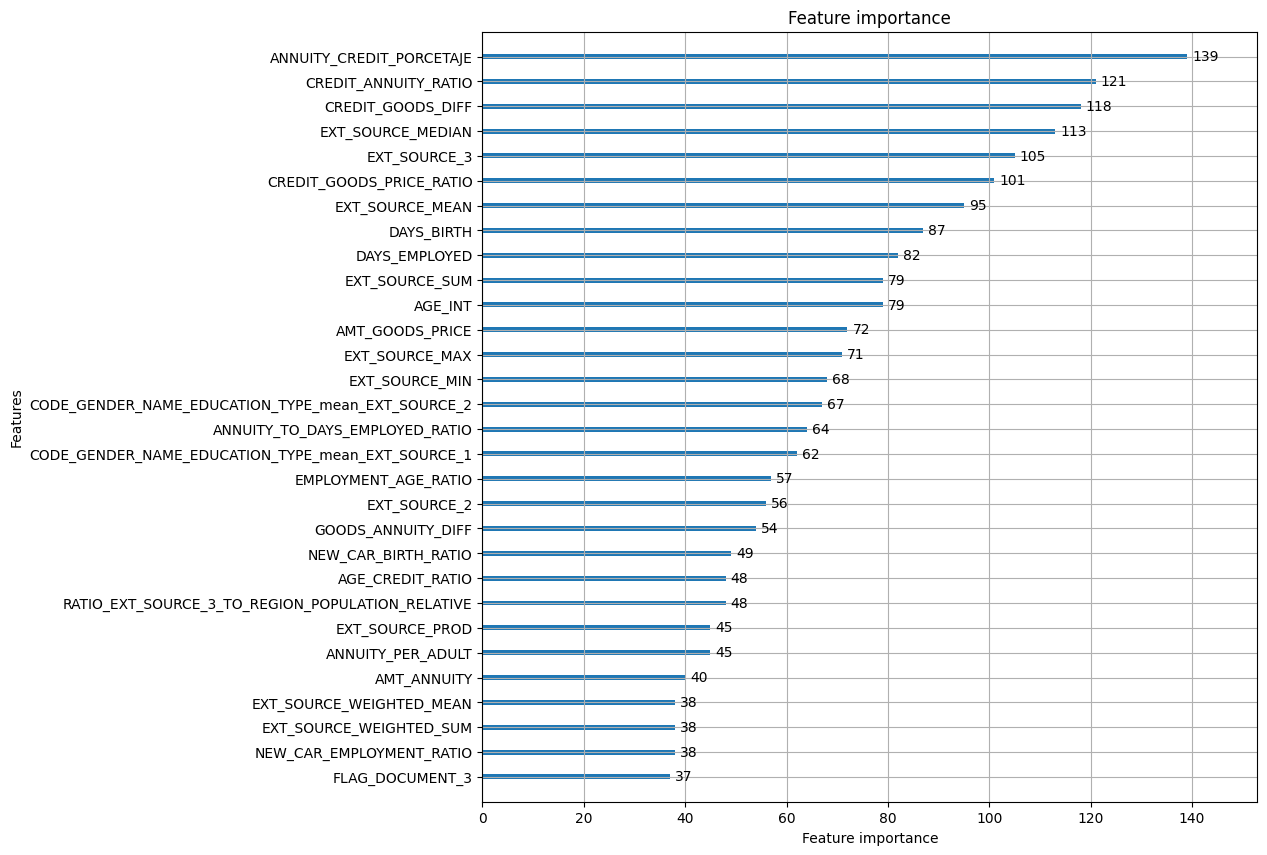

In [13]:
#Vamos a ver la importancia de las variables en el modelo para sacar ideas de cara al feature engineering
lgb.plot_importance(model_train, max_num_features=30, figsize=(10, 10), importance_type='split')
plt.show()

In [8]:
#Optimización de hiperparámetros con XGBoost
space_xgb = {
    'max_depth': hp.quniform('max_depth', 5, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.03), np.log(0.1)),
    'n_estimators': hp.quniform('n_estimators', 900, 1200, 10),
    'min_child_weight': hp.quniform('min_child_weight', 1, 4, 1),
    'subsample': hp.uniform('subsample', 0.6, 0.7),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 0.8),
    'gamma': hp.loguniform('gamma', np.log(0.1), np.log(10)),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(0.1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(10))
}
trials_xgb = Trials()

In [9]:
def objective_xgb(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])


    model_xgb = XGBClassifier(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        use_label_encoder=False,
        random_state=42,
        eval_metric='auc'
    )

    score = cross_val_score(model_xgb, X_train, Y_train, scoring='roc_auc', cv=3).mean()

    return {'loss': -score, 'status': STATUS_OK}

In [ ]:
best_xgb = fmin(
    fn=objective_xgb,
    space=space_xgb,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_xgb,
    rstate= np.random.default_rng(42)
)

best_xgb['max_depth'] = int(best_xgb['max_depth'])
best_xgb['n_estimators'] = int(best_xgb['n_estimators'])
best_xgb['min_child_weight'] = int(best_xgb['min_child_weight'])
print("Mejores hiperparámetros: ", best_xgb)

In [12]:

#Cargar los mejores valores sin tener que recalcularlos
with open("best_hyperparameters_xgb.json", "r") as f:
    best_xgb = json.load(f)

In [ ]:
model_optimizado_xgb = XGBClassifier(
    max_depth=best_xgb['max_depth'],
    learning_rate=best_xgb['learning_rate'],
    n_estimators=best_xgb['n_estimators'],
    min_child_weight=best_xgb['min_child_weight'],
    subsample=best_xgb['subsample'],
    colsample_bytree=best_xgb['colsample_bytree'],
    gamma=best_xgb['gamma'],
    reg_alpha=best_xgb['reg_alpha'],
    reg_lambda=best_xgb['reg_lambda'],
    use_label_encoder=False,
    random_state=42,
    eval_metric='auc',
)

model_optimizado_xgb.fit(X_train, Y_train)
auc_roc_xgb = roc_auc_score(Y_test, model_optimizado_xgb.predict_proba(X_test)[:,1])
print("AUC-ROC del modelo XGBoost optimizado con nuevos parámetros: ", auc_roc_xgb)


In [ ]:
#LightGBM
from sklearn.model_selection import RandomizedSearchCV

# Remove special characters from column names
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

param_dist = {
    'num_leaves':[20,31,40,50],
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[100,200,300],
    'min_child_samples':[10,20,30],
    'feature_fraction':[0.6,0.8,1],
    }

lgb_model = LGBMClassifier(random_state=42)

lgb_random_search = RandomizedSearchCV(estimator=lgb_model, 
                                       param_distributions=param_dist,
                                       n_iter=20,
                                       scoring='roc_auc',
                                       cv=3,
                                       verbose=1,
                                       random_state=42)

lgb_random_search.fit(X_train, Y_train)

#Evaluación
print("Mejores parámetros:", lgb_random_search.best_params_)
print("Mejor AUC-ROC:", lgb_random_search.best_score_)

In [ ]:
#XGBoost

param_dist = {
    'max_depth':[3,5,7,9],
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[100,200,300],
    'subsample':[0.6,0.8,1],
    'colsample_bytree':[0.6,0.8,1],
    'gamma':[0,1,5],
    }

xgb_model = XGBClassifier(random_state=42)

xgb_random_search = RandomizedSearchCV(estimator=xgb_model, 
                                       param_distributions=param_dist,
                                       n_iter=20,
                                       scoring='roc_auc',
                                       cv=3,
                                       verbose=1,
                                       random_state=42)

xgb_random_search.fit(X_train, Y_train)



#Evaluación
print("Mejores parámetros:", xgb_random_search.best_params_)
print("Mejor AUC-ROC:", xgb_random_search.best_score_)


In [ ]:
#Neural Network
nn_model = MLPClassifier(random_state=42)
nn_model.fit(X_train, Y_train)
nn_predictions = nn_model.predict_proba(X_test)[:, 1]

#Evaluación
nn_auc = roc_auc_score(Y_test, nn_predictions)
print(f"Neural Network AUC: {nn_auc:.4f}")

In [ ]:
#Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, Y_train)
rf_predictions = rf_model.predict_proba(X_test)[:, 1]

#Evaluación
rf_auc = roc_auc_score(Y_test, rf_predictions)
print(f"Random Forest AUC: {rf_auc:.4f}")

In [ ]:
#Extra Trees
from sklearn.ensemble import ExtraTreesClassifier
et_model = ExtraTreesClassifier(random_state=42)
et_model.fit(X_train, Y_train)
et_predictions = et_model.predict_proba(X_test)[:, 1]

#Evaluación
et_auc = roc_auc_score(Y_test, et_predictions) 
print(f"Extra Trees AUC: {et_auc:.4f}")


In [ ]:
#Regresión Logística
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, Y_train)
lr_predictions = lr_model.predict_proba(X_test)[:, 1]

#Evaluación
lr_auc = roc_auc_score(Y_test, lr_predictions)
print(f"Logistic Regression AUC: {lr_auc:.4f}")

In [ ]:
#SVM
from sklearn.svm import SVC
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, Y_train)
svm_predictions = svm_model.predict_proba(X_test)[:, 1]

#Evaluación
svm_auc = roc_auc_score(Y_test, svm_predictions)
print(f"SVM AUC: {svm_auc:.4f}")